In [2]:
# Cell 1
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# Cell 2 – fusion config for ALL 3 modalities, edit this for other combinations
%%writefile /content/drive/Shareddrives/ECS289L/fusion_config.yaml
modalities:
  cog:
    csv: /content/drive/Shareddrives/ECS289L/embeddings/cog/embeddings.csv
    dim: 32
  genetics:
    csv: /content/drive/Shareddrives/ECS289L/embeddings/genetics_mlp/embeddings_imputed.csv
    dim: 128
  mri:
    csv: /content/drive/Shareddrives/ECS289L/embeddings/mri/embeddings.csv
    dim: 128

fusion:
  hidden: 256
  heads: 4

train:
  batch: 32
  epochs: 30
  lr: 3e-4
  device: cuda
  output: /content/drive/Shareddrives/ECS289L/results/triple_modal/fusion_all.pt

Overwriting /content/drive/Shareddrives/ECS289L/fusion_config.yaml


In [3]:
# Cell 3: run_fusion.py (training only, metrics saved)
%%writefile /content/run_fusion.py
#!/usr/bin/env python3
import os
import argparse
import yaml
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import json

from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    confusion_matrix, roc_auc_score
)

class FusionDataset(Dataset):
    def __init__(self, cfg):
        self.records = {}
        self.modalities = list(cfg['modalities'].keys())
        for mod in self.modalities:
            df = pd.read_csv(cfg['modalities'][mod]['csv'])
            self.records[mod] = dict(zip(df.RID, df.path))
        sets = [set(self.records[m].keys()) for m in self.modalities]
        self.rids = sorted(set.intersection(*sets))
        labels = pd.read_csv(cfg['train_master']).set_index('RID')['pMCI']
        self.y = labels.loc[self.rids].values.astype('float32')

    def __len__(self):
        return len(self.rids)

    def __getitem__(self, idx):
        rid = self.rids[idx]
        feats = [torch.from_numpy(np.load(self.records[m][rid])).float()
                 for m in self.modalities]
        label = torch.tensor(self.y[idx]).float()
        return feats, label

class CrossModal(nn.Module):
    def __init__(self, dims, hidden, heads):
        super().__init__()
        self.proj = nn.ModuleList([nn.Linear(d, hidden) for d in dims])
        self.attn = nn.MultiheadAttention(hidden, heads, batch_first=True)
        self.classifier = nn.Sequential(
            nn.LayerNorm(hidden),
            nn.Dropout(0.5),
            nn.Linear(hidden, 1)
        )

    def forward(self, feats):
        h = torch.stack([p(x) for p, x in zip(self.proj, feats)], dim=1)
        h2, _ = self.attn(h, h, h)
        h3 = h2.mean(dim=1)
        return self.classifier(h3).squeeze(-1)

def train_model(cfg):
    from sklearn.model_selection import train_test_split
    import torch.optim as optim

    results_dir = os.path.dirname(cfg['train']['output'])
    os.makedirs(results_dir, exist_ok=True)

    # — build dataset & splits —
    ds = FusionDataset(cfg)
    indices = list(range(len(ds)))
    labels  = ds.y.tolist()
    idx_trainval, idx_test = train_test_split(
        indices, test_size=0.2, random_state=42, stratify=labels
    )
    train_idx, val_idx = train_test_split(
        idx_trainval, test_size=0.25, random_state=42,
        stratify=[labels[i] for i in idx_trainval]
    )

    train_loader = DataLoader(Subset(ds, train_idx), batch_size=cfg['train']['batch'], shuffle=True)
    val_loader   = DataLoader(Subset(ds, val_idx), batch_size=cfg['train']['batch'], shuffle=False)
    test_loader  = DataLoader(Subset(ds, idx_test), batch_size=cfg['train']['batch'], shuffle=False)

    device = torch.device(cfg['train']['device'])
    dims = [cfg['modalities'][m]['dim'] for m in ds.modalities]
    model = CrossModal(dims, cfg['fusion']['hidden'], cfg['fusion']['heads']).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=cfg['train']['lr'], weight_decay=1e-2)
    criterion = nn.BCEWithLogitsLoss()

    # containers for metrics
    train_losses, val_losses = [], []
    train_aucs,   val_aucs   = [], []

    best_auc = 0.0

    for epoch in range(1, cfg['train']['epochs'] + 1):
        # — training pass —
        model.train()
        total_loss = 0.0
        for feats, yb in train_loader:
            feats = [f.to(device) for f in feats]
            yb    = yb.to(device)
            optimizer.zero_grad()
            logits = model(feats)
            loss   = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * yb.size(0)
        epoch_train_loss = total_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # computing train ROC-AUC
        model.eval()
        preds_t, labels_t = [], []
        with torch.no_grad():
            for feats, yb in train_loader:
                feats = [f.to(device) for f in feats]
                out   = model(feats).cpu().numpy()
                preds_t.extend(out.tolist())
                labels_t.extend(yb.numpy().tolist())
        train_aucs.append(roc_auc_score(labels_t, preds_t))

        # — validation pass
        val_loss_accum = 0.0
        preds_v, labels_v = [], []
        with torch.no_grad():
            for feats, yb in val_loader:
                feats = [f.to(device) for f in feats]
                yb    = yb.to(device)
                logits = model(feats)
                val_loss_accum += criterion(logits, yb).item() * yb.size(0)
                preds_v.extend(logits.cpu().numpy().tolist())
                labels_v.extend(yb.cpu().numpy().tolist())

        val_losses.append(val_loss_accum / len(val_loader.dataset))
        epoch_val_auc = roc_auc_score(labels_v, preds_v)
        val_aucs.append(epoch_val_auc)

        print(f"Epoch {epoch:02d} → Train Loss: {epoch_train_loss:.4f}, "
              f"Val Loss: {val_losses[-1]:.4f}, Val ROC-AUC: {epoch_val_auc:.4f}")

        if epoch_val_auc > best_auc:
            best_auc = epoch_val_auc
            torch.save(model.state_dict(), cfg['train']['output'])

    print(f"best Val ROC-AUC: {best_auc:.4f} (model saved)")

    # — final test evaluation —
    model.load_state_dict(torch.load(cfg['train']['output']))
    model.eval()
    test_preds, test_labels = [], []
    with torch.no_grad():
        for feats, yb in test_loader:
            feats = [f.to(device) for f in feats]
            out   = model(feats).cpu().numpy()
            test_preds.extend(out.tolist())
            test_labels.extend(yb.numpy().tolist())

    test_probs  = np.array(test_preds)
    test_binary = (test_probs >= 0.5).astype(int)
    test_auc    = roc_auc_score(test_labels, test_probs)

    results = {
        'auc': test_auc,
        'accuracy': accuracy_score(test_labels, test_binary),
        'precision': precision_score(test_labels, test_binary),
        'recall': recall_score(test_labels, test_binary),
        'confusion_matrix': confusion_matrix(test_labels, test_binary).tolist()
    }
    # save test results
    with open(os.path.join(results_dir, 'results.json'), 'w') as f:
        json.dump(results, f, indent=4)

    # save full metrics history
    metrics = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_aucs': train_aucs,
        'val_aucs': val_aucs,
        'test_labels': test_labels,
        'test_probs': test_preds,
        'test_binary': test_binary.tolist()
    }
    with open(os.path.join(results_dir, 'metrics_history.json'), 'w') as f:
        json.dump(metrics, f, indent=4)

    print(f"✅ Metrics & history saved under {results_dir}")

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('--config', required=True, help='Path to fusion_config.yaml')
    args = parser.parse_args()

    with open(args.config) as f:
        cfg = yaml.safe_load(f)

    # to ensure correct types
    cfg['train']['batch']  = int(cfg['train']['batch'])
    cfg['train']['epochs'] = int(cfg['train']['epochs'])
    cfg['train']['lr']     = float(cfg['train']['lr'])
    cfg['fusion']['hidden']= int(cfg['fusion']['hidden'])
    cfg['fusion']['heads'] = int(cfg['fusion']['heads'])

    if 'train_master' not in cfg:
        cfg['train_master'] = os.path.join(os.path.dirname(args.config), 'master_subjects.csv')

    train_model(cfg)


Writing /content/run_fusion.py


In [4]:
# === Cell 4: Train Fusion Model ===
!python /content/run_fusion.py \
  --config /content/drive/Shareddrives/ECS289L/fusion_config.yaml


Epoch 01 → Train Loss: 0.7289, Val Loss: 0.5253, Val ROC-AUC: 0.9773
Epoch 02 → Train Loss: 0.5427, Val Loss: 0.3626, Val ROC-AUC: 0.9841
Epoch 03 → Train Loss: 0.4686, Val Loss: 0.2646, Val ROC-AUC: 0.9864
Epoch 04 → Train Loss: 0.3685, Val Loss: 0.1969, Val ROC-AUC: 0.9841
Epoch 05 → Train Loss: 0.2922, Val Loss: 0.2257, Val ROC-AUC: 0.9818
Epoch 06 → Train Loss: 0.2667, Val Loss: 0.3603, Val ROC-AUC: 0.9727
Epoch 07 → Train Loss: 0.3462, Val Loss: 0.2715, Val ROC-AUC: 0.9773
Epoch 08 → Train Loss: 0.2746, Val Loss: 0.3227, Val ROC-AUC: 0.9886
Epoch 09 → Train Loss: 0.2972, Val Loss: 0.1651, Val ROC-AUC: 0.9932
Epoch 10 → Train Loss: 0.2659, Val Loss: 0.1427, Val ROC-AUC: 0.9909
Epoch 11 → Train Loss: 0.2787, Val Loss: 0.1540, Val ROC-AUC: 0.9909
Epoch 12 → Train Loss: 0.2529, Val Loss: 0.1928, Val ROC-AUC: 0.9909
Epoch 13 → Train Loss: 0.2696, Val Loss: 0.1993, Val ROC-AUC: 0.9909
Epoch 14 → Train Loss: 0.2857, Val Loss: 0.1703, Val ROC-AUC: 0.9909
Epoch 15 → Train Loss: 0.2511, Val

In [5]:
import os

def print_folder_structure(root_folder):
    for root, dirs, files in os.walk(root_folder):
        level = root.replace(root_folder, '').count(os.sep)
        indent = ' ' * 4 * level
        print(f'{indent}{os.path.basename(root)}/')
        sub_indent = ' ' * 4 * (level + 1)
        for f in files:
            print(f'{sub_indent}{f}')

# Shared Drive path
root_folder = '/content/drive/Shareddrives/ECS289L/results'
print_folder_structure(root_folder)


results/
    all_modality_results_summary.csv
    genetic/
        roc_curve.png
        confusion_matrix.png
        pr_curve.png
        sens_spec.png
        genetic_test_metrics.csv
        val_auc.csv
        val_auc_curve.png
        genetic_test_summary.csv
        genetic_test_roc.png
        genetic_test_pr.png
        genetic_test_cm.png
        genetic_cv_results.csv
    cognitive/
        validation_cm.png
        loss_accuracy_over_epochs_cognitive.png
        training_cm.png
        f1_auc_over_epochs_cognitive.png
    genetic1/
        validation_cm.png
        loss_accuracy_over_epochs_genetic.png
        training_cm.png
        f1_auc_over_epochs_genetic.png
    mri/
        training_cm.png
        validation_cm.png
        loss_accuracy_over_epochs_mri.png
        f1_auc_over_epochs_mri.png
    single_modal/
        cognitive/
            fusion_mri_only.pt
            fusion_all.pt
            fusion_gen_only.pt
            fusion_cog_only.pt
            results.json

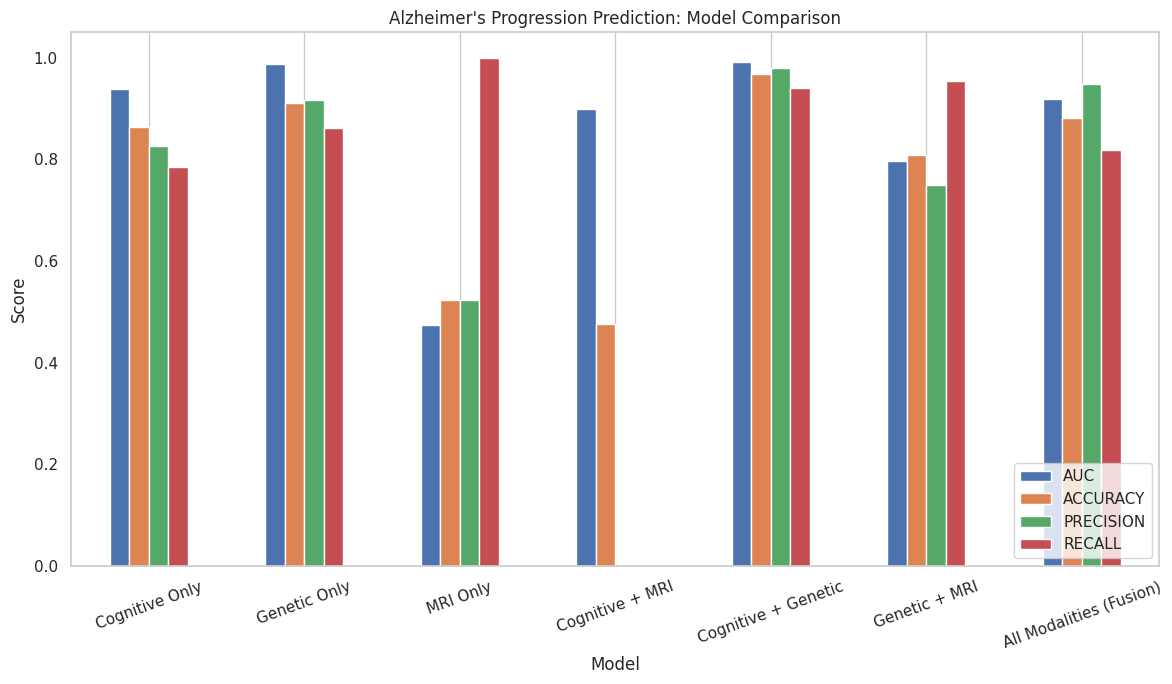

==== STATS BY MODEL ====

--- Cognitive Only ---
AUC:      0.939
Accuracy: 0.864
Precision:0.827
Recall:   0.785

--- Genetic Only ---
AUC:      0.988
Accuracy: 0.911
Precision:0.917
Recall:   0.863

--- MRI Only ---
AUC:      0.475
Accuracy: 0.524
Precision:0.524
Recall:   1.000

--- Cognitive + MRI ---
AUC:      0.900
Accuracy: 0.476
Precision:0.000
Recall:   0.000

--- Cognitive + Genetic ---
AUC:      0.991
Accuracy: 0.968
Precision:0.980
Recall:   0.941

--- Genetic + MRI ---
AUC:      0.798
Accuracy: 0.810
Precision:0.750
Recall:   0.955

--- All Modalities (Fusion) ---
AUC:      0.918
Accuracy: 0.881
Precision:0.947
Recall:   0.818

==== COMPARISON SUMMARY FOR REPORTING ====
Best AUC: 0.991 (Cognitive + Genetic)
Best single modality: Genetic Only with AUC 0.988
Fusion model improves AUC by 0.003 over best single modality.

For AUC: Fusion = 0.918 vs best single (Genetic Only) = 0.988
For ACCURACY: Fusion = 0.881 vs best single (Genetic Only) = 0.911
For PRECISION: Fusion = 0.947

In [6]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# root results directory
base_path = "/content/drive/Shareddrives/ECS289L/results"

# paths and display names for all runs
modalities = {
    "Cognitive Only": f"{base_path}/single_modal/cognitive/results.json",
    "Genetic Only": f"{base_path}/single_modal/genetic/results.json",
    "MRI Only": f"{base_path}/single_modal/mri/results.json",
    "Cognitive + MRI": f"{base_path}/dual_modal/cog_mri/results.json",
    "Cognitive + Genetic": f"{base_path}/dual_modal/cog_gen/results.json",
    "Genetic + MRI": f"{base_path}/dual_modal/gen_mri/results.json",
    "All Modalities (Fusion)": f"{base_path}/triple_modal/results.json",  # Or fusion_all/results.json if that's your actual folder
}

# Load results
results = []
missing = []
for label, path in modalities.items():
    if os.path.exists(path):
        with open(path, 'r') as f:
            d = json.load(f)
            d['Model'] = label
            results.append(d)
    else:
        missing.append(label)

# missing warning
if missing:
    print("Missing results for:", ', '.join(missing))

# DataFrame for charts and stats
df = pd.DataFrame(results)
df.set_index("Model", inplace=True)
# only numeric metrics for plotting
metrics_to_plot = ["auc", "accuracy", "precision", "recall"]
plot_df = df[metrics_to_plot]

# Plot grouped bar chart
sns.set(style="whitegrid")
plot_df.plot(kind="bar", figsize=(12,7), rot=20)
plt.title("Alzheimer's Progression Prediction: Model Comparison")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.legend([m.upper() for m in metrics_to_plot], loc="lower right")
plt.tight_layout()
plt.grid(axis='y')
plt.show()

# comparison stats for each model
print("==== STATS BY MODEL ====")
for model, row in plot_df.iterrows():
    print(f"\n--- {model} ---")
    print(f"AUC:      {row['auc']:.3f}")
    print(f"Accuracy: {row['accuracy']:.3f}")
    print(f"Precision:{row['precision']:.3f}")
    print(f"Recall:   {row['recall']:.3f}")

# best model and the improvement from single to fusion
print("\n==== COMPARISON SUMMARY FOR REPORTING ====")
best_model = plot_df['auc'].idxmax()
worst_single = plot_df.loc[["Cognitive Only", "Genetic Only", "MRI Only"], "auc"].idxmax()
improvement = plot_df.loc[best_model, "auc"] - plot_df.loc[worst_single, "auc"]
print(f"Best AUC: {plot_df.loc[best_model, 'auc']:.3f} ({best_model})")
print(f"Best single modality: {worst_single} with AUC {plot_df.loc[worst_single, 'auc']:.3f}")
print(f"Fusion model improves AUC by {improvement:.3f} over best single modality.\n")

# Example statement to use for your RQ answers
for metric in metrics_to_plot:
    fusion_val = plot_df.loc["All Modalities (Fusion)", metric]
    single_vals = plot_df.loc[["Cognitive Only", "Genetic Only", "MRI Only"], metric]
    best_single = single_vals.idxmax()
    print(
        f"For {metric.upper()}: Fusion = {fusion_val:.3f} vs best single ({best_single}) = {single_vals.max():.3f}"
    )

print("\nYou can now use these stats and plots directly to answer RQ1 and RQ2.")


In [7]:
import os
import json
import pandas as pd

base_path = "/content/drive/Shareddrives/ECS289L/results"

modalities = {
    "Cognitive Only": f"{base_path}/single_modal/cognitive/results.json",
    "Genetic Only": f"{base_path}/single_modal/genetic/results.json",
    "MRI Only": f"{base_path}/single_modal/mri/results.json",
    "Cognitive + MRI": f"{base_path}/dual_modal/cog_mri/results.json",
    "Cognitive + Genetic": f"{base_path}/dual_modal/cog_gen/results.json",
    "Genetic + MRI": f"{base_path}/dual_modal/gen_mri/results.json",
    "All Modalities (Fusion)": f"{base_path}/triple_modal/results.json",
}

rows = []
for name, path in modalities.items():
    if os.path.exists(path):
        with open(path, 'r') as f:
            d = json.load(f)
            cm = d.get("confusion_matrix", [[None, None], [None, None]])
            if all(isinstance(x, int) for row in cm for x in row):
                tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
                sensitivity = tp / (tp + fn) if (tp + fn) else float('nan')
                specificity = tn / (tn + fp) if (tn + fp) else float('nan')
            else:
                sensitivity = specificity = float('nan')
            rows.append({
                "Model": name,
                "Sensitivity": sensitivity,
                "Specificity": specificity
            })
    else:
        print("Missing:", path)

df = pd.DataFrame(rows)
print(df)


                     Model  Sensitivity  Specificity
0           Cognitive Only     0.784810     0.907801
1             Genetic Only     0.862745     0.945205
2                 MRI Only     1.000000     0.000000
3          Cognitive + MRI     0.000000     1.000000
4      Cognitive + Genetic     0.941176     0.986301
5            Genetic + MRI     0.954545     0.650000
6  All Modalities (Fusion)     0.818182     0.950000


In [8]:
import os
import json
import pandas as pd
from sklearn.metrics import f1_score

 root results directory
base_path = "/content/drive/Shareddrives/ECS289L/results"

# result file paths
modalities = {
    "Cognitive Only": f"{base_path}/single_modal/cognitive/results.json",
    "Genetic Only": f"{base_path}/single_modal/genetic/results.json",
    "MRI Only": f"{base_path}/single_modal/mri/results.json",
    "Cognitive + MRI": f"{base_path}/dual_modal/cog_mri/results.json",
    "Cognitive + Genetic": f"{base_path}/dual_modal/cog_gen/results.json",
    "Genetic + MRI": f"{base_path}/dual_modal/gen_mri/results.json",
    "All Modalities (Fusion)": f"{base_path}/triple_modal/results.json",
}

results = []
for name, path in modalities.items():
    if os.path.exists(path):
        with open(path, 'r') as f:
            d = json.load(f)
            cm = d.get("confusion_matrix", [[None, None], [None, None]])
            try:
                tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
                sensitivity = tp / (tp + fn) if (tp + fn) else float('nan')
                specificity = tn / (tn + fp) if (tn + fp) else float('nan')
            except Exception:
                sensitivity = specificity = float('nan')
            # F1-score
            try:
                preds = d["predicted_probs"]
                labels = d["true_labels"]
                binary_preds = [1 if p >= 0.5 else 0 for p in preds]
                f1 = f1_score(labels, binary_preds)
            except Exception:
                f1 = float('nan')
            results.append({
                "Modality": name,
                "Accuracy": d.get("accuracy", float('nan')),
                "AUC": d.get("auc", float('nan')),
                "Precision": d.get("precision", float('nan')),
                "Recall": d.get("recall", float('nan')),
                "Sensitivity": sensitivity,
                "Specificity": specificity,
                "F1-Score": f1,
            })
    else:
        print("Missing:", path)

# Present as a DataFrame
df = pd.DataFrame(results)
df = df[["Modality", "Accuracy", "AUC", "Precision", "Recall", "Sensitivity", "Specificity", "F1-Score"]]
print(df.to_string(index=False, float_format="%.3f"))

# Save table as CSV for future plotting
df.to_csv(f"{base_path}/all_modality_results_summary.csv", index=False)


               Modality  Accuracy   AUC  Precision  Recall  Sensitivity  Specificity  F1-Score
         Cognitive Only     0.864 0.939      0.827   0.785        0.785        0.908     0.805
           Genetic Only     0.911 0.988      0.917   0.863        0.863        0.945     0.889
               MRI Only     0.524 0.475      0.524   1.000        1.000        0.000     0.688
        Cognitive + MRI     0.476 0.900      0.000   0.000        0.000        1.000     0.000
    Cognitive + Genetic     0.968 0.991      0.980   0.941        0.941        0.986     0.960
          Genetic + MRI     0.810 0.798      0.750   0.955        0.955        0.650     0.840
All Modalities (Fusion)     0.881 0.918      0.947   0.818        0.818        0.950       NaN


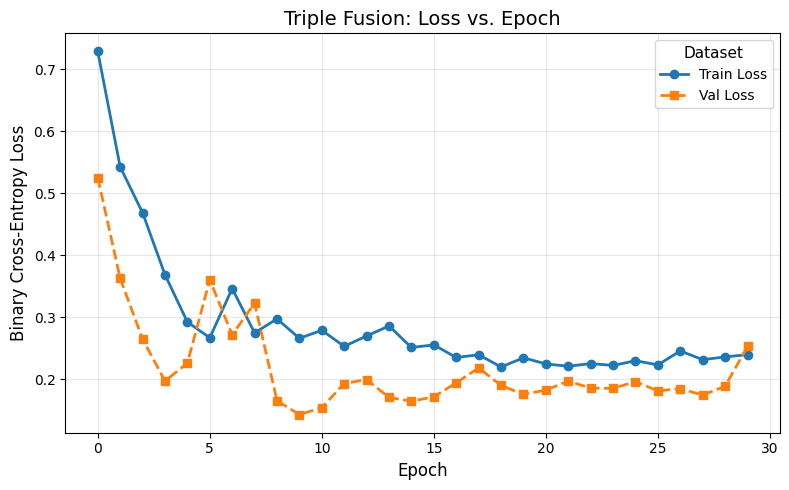

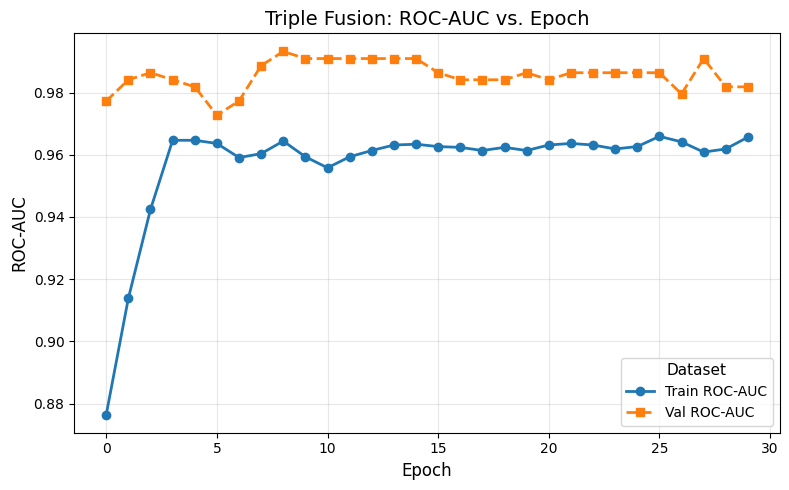

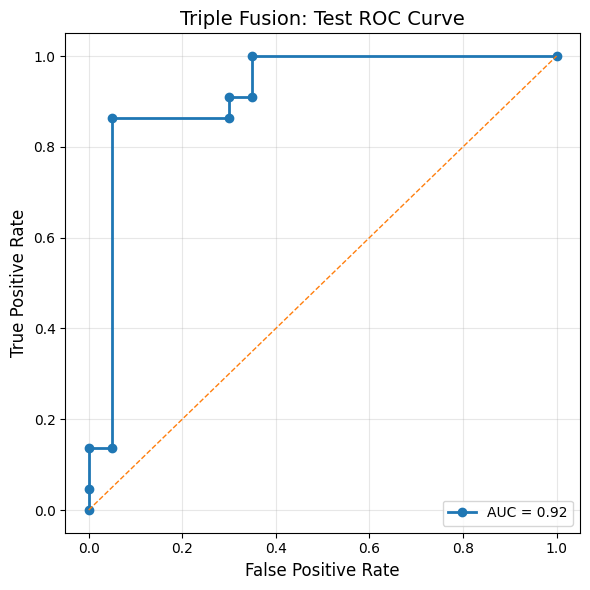

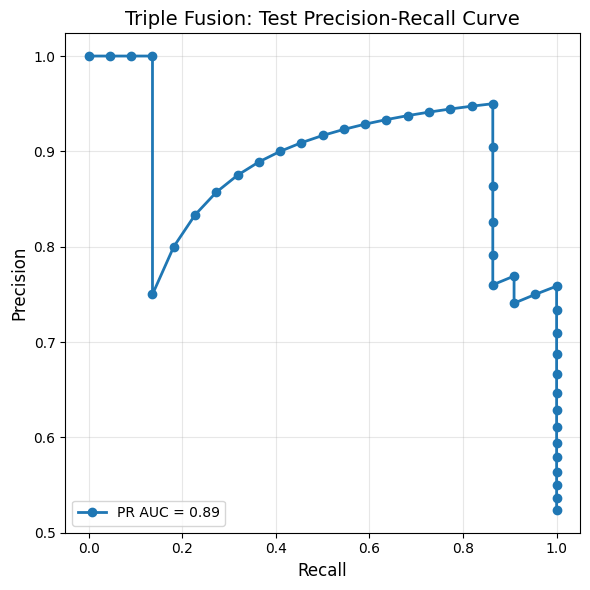

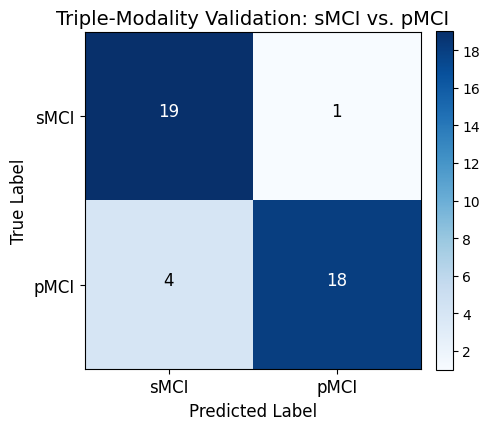

In [5]:
# Cell 4: Standalone plotting
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import roc_curve, precision_recall_curve, auc


results_dir = "/content/drive/Shareddrives/ECS289L/results/triple_modal"

# load metrics & results
metrics = json.load(open(os.path.join(results_dir, 'metrics_history.json')))
results = json.load(open(os.path.join(results_dir, 'results.json')))

train_losses = metrics['train_losses']
val_losses   = metrics['val_losses']
train_aucs    = metrics['train_aucs']
val_aucs      = metrics['val_aucs']
test_labels   = metrics['test_labels']
test_probs    = metrics['test_probs']

model_desc = "Triple Fusion"

# 1) Loss Curve
plt.figure(figsize=(8,5))
plt.plot(train_losses, marker='o', linestyle='-', linewidth=2, markersize=6, label='Train Loss')
plt.plot(val_losses,   marker='s', linestyle='--', linewidth=2, markersize=6, label='Val Loss')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Binary Cross-Entropy Loss', fontsize=12)
plt.title(f'{model_desc}: Loss vs. Epoch', fontsize=14)
plt.legend(title='Dataset', fontsize=10, title_fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 2) ROC-AUC Curve Across Epochs
plt.figure(figsize=(8,5))
plt.plot(train_aucs, marker='o', linestyle='-', linewidth=2, markersize=6, label='Train ROC-AUC')
plt.plot(val_aucs,   marker='s', linestyle='--', linewidth=2, markersize=6, label='Val ROC-AUC')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('ROC-AUC', fontsize=12)
plt.title(f'{model_desc}: ROC-AUC vs. Epoch', fontsize=14)
plt.legend(title='Dataset', fontsize=10, title_fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 3) Test ROC Curve
fpr, tpr, _ = roc_curve(test_labels, test_probs)
test_auc    = results['auc']
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, marker='o', linewidth=2, markersize=6, label=f'AUC = {test_auc:.2f}')
plt.plot([0,1], [0,1], linestyle='--', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'{model_desc}: Test ROC Curve', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 4) Precision-Recall Curve
precision, recall, _ = precision_recall_curve(test_labels, test_probs)
pr_auc = auc(recall, precision)
plt.figure(figsize=(6,6))
plt.plot(recall, precision, marker='o', linewidth=2, markersize=6, label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title(f'{model_desc}: Test Precision-Recall Curve', fontsize=14)
plt.legend(loc='lower left', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 5) Confusion Matrix
cm = np.array(results['confusion_matrix'])
classes = ['sMCI', 'pMCI']
plt.figure(figsize=(5,5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(f'Triple-Modality Validation: sMCI vs. pMCI', fontsize=14)  # or adjust as above
plt.colorbar(fraction=0.046, pad=0.04)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, fontsize=12)
plt.yticks(tick_marks, classes, fontsize=12)
thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black",
             fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.grid(False)
plt.tight_layout()
plt.show()
